In [116]:
import sys
sys.path.insert(1, '../src/magpies/')
from magpies import *
from atmos import *
import numpy as np
from math import *
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt

In [117]:
## Radius and mass of neutron star
Rns = 12  ## km
Mns = 1.4 ## M_solar
Tb = pow(10, 7.1730)  ## K
Bp = 1e13 ## G

## Instrument and exposure
eph = np.linspace (0.20, 3.00, 32) ## Nicer soft X-ray range
nphot = 1e5

g14c = g14 (Rns, Mns) ## computing the free fall acceleration
 
print ('g14 = ', g14c)

g14 =  1.6054273795798544


In [118]:
delta_eph = eph[1] - eph[0]
print (delta_eph)

0.0903225806451613


In [119]:
## Initialising the atmosphere
atm_iron_2003 = NS_atmosphere ('Potekhin_2003_iron', g14c, Tb, Bp)
atm_iron_2003.describe ()

Surface temperatures for magnetised envelope of NS
Following fit from Potekhin, Yakovlev, Chabrier & Gnedin (2003) for iron envelope
The Astrophysical Journal, Volume 594, Issue 1, pp. 404-418  2003ApJ...594..404P
Same fits are provided in Beznogov, Potekhin & Yakovlev (2021) for iron envelope
Physics Reports, Volume 919, p. 1-68 2021PhR...919....1B


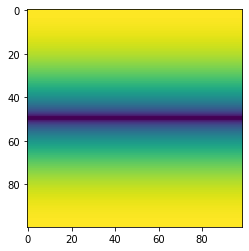

In [120]:
theta = np.linspace (0, pi, 100)  ## theta coordinates
phi   = np.linspace (0, 2*pi, 99) ## phi coordinates

theta1, phi1 = np.meshgrid (theta, phi)

Ts = atm_iron_2003.Ts (theta1) ## Surface temperatures

#for i in range (0, Ts.shape[0]):
#    for j in range (0, Ts.shape[1]):
#        Ts[i,j] = 1e6

plt.imshow(Ts.T)

In [121]:
## Here we produce and store the soft X-ray spectra for two orientations: pole on and equatorial 
sp_red_n, map_of_visible = get_redshifted_spectra_pole_photons (theta, phi, Ts, Rns, Mns, eph, nphot)
sp_red_n_eq, map_of_visible = get_redshifted_spectra_equator_photons (theta, phi, Ts, Rns, Mns, eph, nphot)

../src/magpies/magpies.py:458: RuntimeWarning: overflow encountered in exp
  sp_red = sp_red +  Df * 15.0 * sigma_SB / ( pow(pi, 5) * pow(kB, 4)) * np.sin(theta[j]) * np.cos(al)  * np.power(eph, 2) / (np.exp(eph / kB / Ts_inf[i,j]) - 1.0) * dtheta * dphi
../src/magpies/magpies.py:148: RuntimeWarning: divide by zero encountered in log
  x = (1.0 - u)*y*(1.0 + u*u*y*y/112.0 - e/100.0*u*y*(np.log(1-y/2.0) + y/2))
../src/magpies/magpies.py:150: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(res)
../src/magpies/magpies.py:624: RuntimeWarning: overflow encountered in exp
  sp_red = sp_red +  Df * 15.0 * sigma_SB / ( pow(pi, 5) * pow(kB, 4)) * np.sin(theta[j]) * np.cos(al) * np.power(eph, 2) / (np.exp(eph / kB / Ts_inf[i,j]) - 1.0) * dtheta * dphi


In [122]:
Teff = compute_Teff (theta, phi, Rns, Ts)
bb1 = single_BB_photons (1.07*Teff, Rns, Mns, eph, nphot)
bb2 = two_BB_photons ([0.4613, 0.2819, 1.0225, 1.1914], Teff, Rns, Mns, eph, nphot)

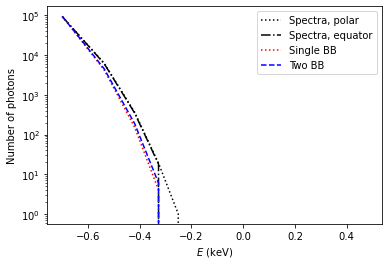

In [123]:
plt.plot (np.log10(eph), sp_red_n, 'k:', label='Spectra, polar')
plt.plot (np.log10(eph), sp_red_n_eq, 'k-.', label='Spectra, equator')
plt.plot (np.log10(eph), bb1, 'r:', label='Single BB')
plt.plot (np.log10(eph), bb2, 'b--', label='Two BB')
plt.xlabel(r'$E$ (keV)')
plt.ylabel('Number of photons')
plt.yscale('log')
plt.legend()




In [124]:
res = fit_spectral_model_chi2 (Teff, Rns, Mns, sp_red_n, eph, nphot)
print (res)

bb2_opt = two_BB_photons (res[0:4], Teff, Rns, Mns, eph, nphot)
#bb2_opt = two_BB_photons ([1, 0.001, 1, 0.1], Teff, Rns, Mns, eph, nphot)


[0.5, 0.5, 1.2036108398437497, 1.2036108398437497, 2.091509545882659, 1.000010718113612]


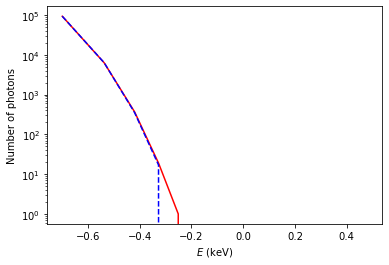

In [125]:
plt.plot (np.log10(eph), sp_red_n, 'r-', label='Spectra, polar')

plt.plot (np.log10(eph), bb2_opt, 'b--', label='Two BB')
plt.xlabel(r'$E$ (keV)')
plt.ylabel('Number of photons')
plt.yscale('log')

In [126]:
print (chi2_1BB (1.2, Teff, Rns, Mns, sp_red_n, eph, nphot))

3.0579874452254825


In [127]:
print (chi2_2BB (res[0:4], Teff, Rns, Mns, sp_red_n, eph, nphot))

2.091220156815135


In [128]:
res_BB1 = single_BB_photons (res[2]*Teff, Rns, Mns, eph, nphot)

In [129]:
res_BB2 = two_BB_photons ([res[0]*2, 0.001, res[2], 0.1], Teff, Rns, Mns, eph, nphot)

../src/magpies/magpies.py:273: RuntimeWarning: overflow encountered in exp
  res = 15.0*sigma_SB / ( pow(pi, 4) * pow(kB, 4)) * np.power(eph, 2) / (np.exp(eph / (kB *Teff_inf)) - 1.0) / (1.0 - xg)


(1, 1000000.0)

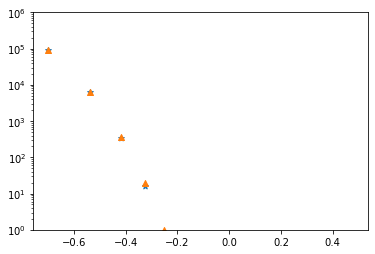

In [130]:
plt.scatter (np.log10(eph), res_BB2, marker='*') #'r-')
plt.scatter (np.log10(eph), sp_red_n, marker='^') #'b--')
plt.yscale('log')
plt.ylim([1,1e6])

In [131]:
print (np.min(res_BB1), np.min(res_BB2), np.min(sp_red_n))

0 0 0


In [132]:
print (res_BB1[0:20])

[93286  6343   352    17     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [133]:
print (res_BB2[0:20])

[93294  6336   351    16     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [134]:
print (sp_red_n[0:20])

[93300  6309   368    19     1     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [135]:
print (np.sum(res_BB1), np.sum(res_BB2), np.sum(sp_red_n))

99998 99997 99997


In [136]:
print (Cstat_1BB (res[2], Teff, Rns, Mns, sp_red_n, eph, nphot))

1.0907456067834533


In [137]:
print (Cstat_2BB (res[0:4], Teff, Rns, Mns, sp_red_n, eph, nphot))

inf


In [138]:
print (fit_spectral_model_Cstat (Teff, Rns, Mns, sp_red_n, eph, nphot))

[0.5, 0.5, 1.2037695312499996, 1.2037695312499996, 1.0892317341525501, 0.19005908215924028]
